In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import string, sqlite3,random

import scripts.TextAnalysis as ta
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import codecs  #this let's us display tweets properly (emojis, etc.)

import scripts.TextAnalysis as ta
import sklearn.cluster as cluster
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator



# Single User Time Series Analysis (50 points)

We will study the posting times for the tweets of a Twitter user to better understand their behavior and interests.

In [2]:
df_all = pd.read_csv("data/tweets_KimKardashian.csv")
df = df_all[['screen_name','created_at','text','retweet_count']]
df.head()

,screen_name,created_at,text,retweet_count
0,KimKardashian,2021-02-19 05:43:54,\U0001f331\U0001f343 Plant based does a body g...,7420
1,KimKardashian,2021-02-18 15:05:39,My beautiful sweet smart baby girl! I love pla...,16702
2,KimKardashian,2021-02-18 03:16:29,Sign up for @lala &amp; @arrogant_tae123\u2019...,275
3,KimKardashian,2021-02-17 14:41:39,Flower Power \U0001f338 \n\n\U0001f4f7 Vanessa...,1844
4,KimKardashian,2021-02-16 17:07:25,I\u2019m really shy https://t.co/TyyXnnRhLu,6255


#### Datetime Column

Add column `created_at_datetime` to the dataframe which is the `created_at` column converted to datetimes.  Then sort the data frame by the values in `created_at_datetime` in ascending order.  Print out the head and the tail of the dataframe's `created_at` column to make sure you sorted correctly (please don't print all the columns, it looks like a mess).

In [3]:
format = "%Y-%m-%d %H:%M:%S"  #2021-02-19 21:04:07
df['created_at_datetime'] = pd.to_datetime(df['created_at'], format = format)
df.sort_values( by = 'created_at_datetime', ascending = True, inplace = True)

print(f"The head of the dataframe is\n{df['created_at'].head()}\n")
print(f"The tail of the dataframe is\n{df['created_at'].tail()}")

The head of the dataframe is
3230    2019-11-13 06:33:24
3229    2019-11-13 06:33:37
3228    2019-11-13 06:33:57
3227    2019-11-13 06:34:58
3226    2019-11-13 06:35:06
Name: created_at, dtype: object

The tail of the dataframe is
4    2021-02-16 17:07:25
3    2021-02-17 14:41:39
2    2021-02-18 03:16:29
1    2021-02-18 15:05:39
0    2021-02-19 05:43:54
Name: created_at, dtype: object


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Mean Tweet Rate

What is the mean tweet rate of the user in units of tweets per day? Use all of the tweets to calculate the rate.  Print out your answer to 2 decimal places (you will be penalized if you print out the wrong number of decimal places).

In [4]:
ntweets = len(df)
duration = df.created_at_datetime.max() - df.created_at_datetime.min()
duration = duration.days

rate_estimate = ntweets/duration

print(f"Duration = {duration} days\nRate estimate = {rate_estimate:.2f} tweets/day")

Duration = 463 days
Rate estimate = 6.98 tweets/day


#### Rolling Window Tweet Rate
Calculate a rolling window estimate of the tweet rate.  Make sure you use the `created_at_datetime` column to calculate the windows and a `tweet_indicator` column to calculate the rate in the windows.  Use window sizes of 1 day and 7 days.  Add columns to your dataframe for the rate with each window size.  For example, the 1 day  rate column can be called `rate_1D`.  Plot the rolling average tweet rates for each window versus the `created_at_datetime` column in a single plot.  Make sure your axes have nice labels with easy to read fontsizes.  Also make sure you have a legend on your plot indicating the window size for each rate.  


In [5]:
df['tweet_indicator'] = np.ones(len(df))
df['rate_1D'] = (df.rolling('1D', on = 'created_at_datetime').sum()['tweet_indicator']-1)* 1/1
df['rate_7D'] = (df.rolling('7D', on = 'created_at_datetime').sum()['tweet_indicator']-1)* 1/7

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

Text(0.5, 1.0, 'KimKardashian')

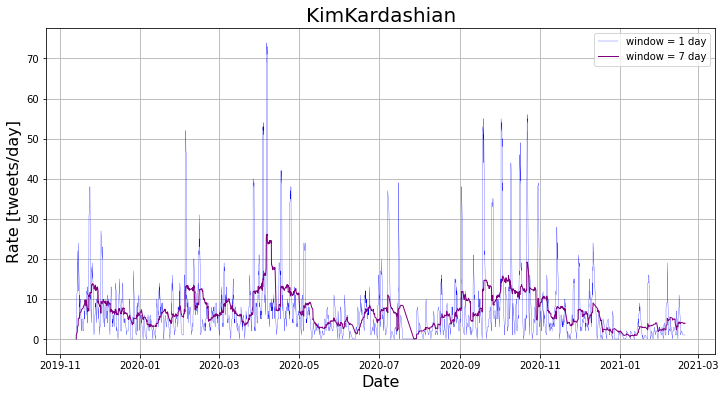

In [6]:
screen_name = 'KimKardashian'
fig = plt.figure(figsize = (12,6))
sns.lineplot(data = df, x = "created_at_datetime", y = "rate_1D",linewidth = 0.25, color = 'blue',label = 'window = 1 day')
sns.lineplot(data = df, x = "created_at_datetime", y = "rate_7D",linewidth = 1, color = 'purple',label = 'window = 7 day')
#plt.ylim( [0, 12  ])
plt.grid()
plt.ylabel("Rate [tweets/day]",fontsize = 16)
plt.xlabel("Date",fontsize = 16)

plt.title(f"{screen_name}",fontsize = 20)
#plt.xlim(datetime.date(2019, 1, 1),datetime.date(2021,1,1))

#### Tweets During Peak Tweet Rate

Find the datetime when the tweet rate with a 1 day window is maximal and call this value `tpeak`.  Print out what `tpeak` is.  Then make a word cloud of the tweets within a 24 hour window ending at `tpeak` (add "kimkardashian" to your stopwords).  What do you think was the reason for such a high tweet rate that day (you won't be penalized if you can't figure this out)?

In [10]:
tpeak = df[ df.rate_1D == df.rate_1D.max()].created_at_datetime.values[0]

print(f"Peak tweet rate on {tpeak}")

Peak tweet rate on 2020-04-06T03:58:07.000000000


In [11]:
tpeak_1 = (df[ df.rate_1D == df.rate_1D.max()].created_at_datetime - datetime.timedelta(days=1)).values[0]
print(f"Peak tweet minus 24 hours rate on {tpeak_1}")

Peak tweet minus 24 hours rate on 2020-04-05T03:58:07.000000000


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


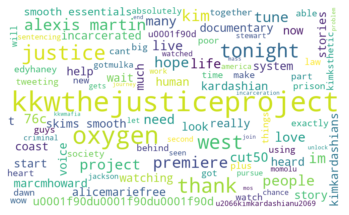

In [14]:
t0 = tpeak - np.timedelta64(24, 'h')
t1 = tpeak 
df1 = df[(df.created_at_datetime>=t0) & (df.created_at_datetime<t1)]

stopwords = set(STOPWORDS)
stopwords.add("kimkardashian")
df1['text_clean'] = df.text.apply(ta.clean_tweet)
text=' '.join(df1.text_clean.tolist()).lower()
wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
wordcloud.generate(text)

fig = plt.figure(figsize = (6,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Histogram of Tweet Day of the Week
Create a column in the dataframe called `day` which has the day of the week of each tweet.  Then make a histogram of the day of the user's tweets. What day of the week has the highest number of tweets?  

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


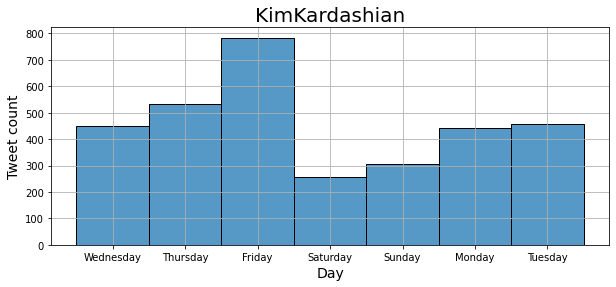

In [49]:
df['day'] = df.created_at_datetime.dt.day_name()   #get the day of the tweet
#df['day'] = df.created_at_datetime.dt.dayofweek   

fig = plt.figure(figsize = (10,4))
sns.histplot(data = df, x = 'day')
plt.title(f"{screen_name}",fontsize = 20)
plt.ylabel("Tweet count",fontsize = 14)
plt.xlabel("Day",fontsize = 14)
plt.grid()
plt.show()

Friday has the highest number of tweets.

#### Tweets During Peak Day of the Week

Make a word cloud of the tweets posted on the day with the highest number of tweets (add "kimkardashian" to your stopwords).  Using the word cloud, propose a reason as to why  there are so many tweets on that day? (*hint: look at television schedule*).  If you are not familiar with American pop culture, don't worry because  we won't deduct points if you can't figure out why the tweet count is so high.

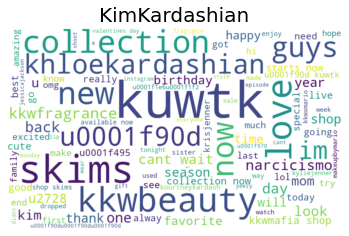

In [51]:
df_day = df[df.day=='Friday']
stopwords = set(STOPWORDS)
stopwords.add(screen_name)
text=' '.join(df_day.text_clean.tolist()).lower()
wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
wordcloud.generate(text)

fig = plt.figure(figsize = (6,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f"{screen_name}",fontsize = 20)

plt.show()

# Geo-location with Tweet Times 

Let's try to figure out where some Twitter users are located using the times they tweet. 

In [53]:
df_2 = pd.read_csv("data/hw7_tweets.csv")
format = "%Y-%m-%d %H:%M:%S"  #2021-02-19 21:04:07
df_2['created_at_datetime'] = pd.to_datetime(df_2['created_at'], format = format)
df_2['hour'] = df_2.created_at_datetime.dt.hour   #get the day of the tweet

#### Screen Names
Print out the screen name of the users in the dataframe.

In [54]:
df_2.screen_name.unique()

array(['Cristiano', 'BTS_twt', 'AOC', 'KingJames'], dtype=object)

#### Tweet Hour Histograms 

Make a histogram of the hour of each tweet for each user in the dataframe.  Title each histogram with the screen name of the user.  Make sure you have 24 bins going from 0 to 23.


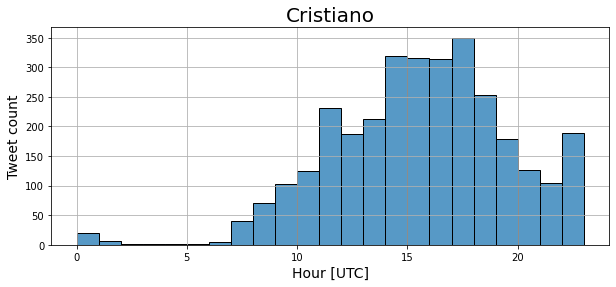

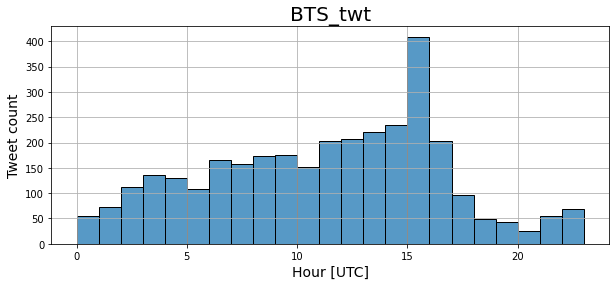

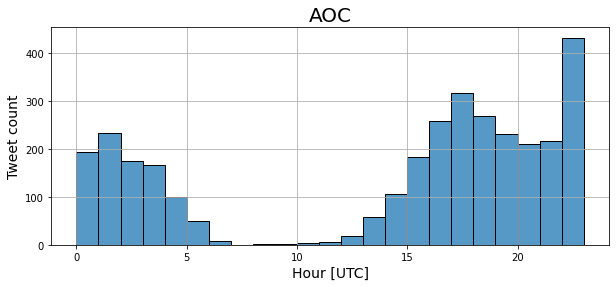

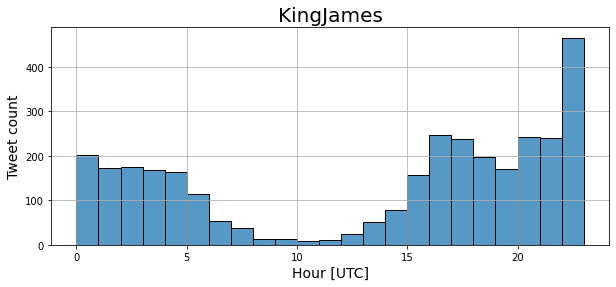

In [58]:
bins = list(range(0,24))
for  name in df_2.screen_name.unique():
    fig = plt.figure(figsize = (10,4))
    sns.histplot(data = df_2[df_2.screen_name ==  name ], x = 'hour',bins = bins)
    plt.title(f"{name}",fontsize = 20)
    plt.ylabel("Tweet count",fontsize = 14)
    plt.xlabel("Hour [UTC]",fontsize = 14)
    plt.grid()
    plt.show()

#### Low Period Tweets

Define a list called `low_hours` of the low period hours when people are sleeping.  You get to choose what these hours are.  Then find the UTC offset for each user so they have the minimum number of tweets in this period.  Print out the screen name and UTC offset for each user.

In [62]:
def geolocate_utc_offset(df,low_hours):
    nlows = []
    utc_offsets = list(range(-11,13))
    for utc_offset in utc_offsets:
        low_hours_offset = [(h-utc_offset)%24 for h in low_hours]
        nlow = len(df1[df1.hour.isin(low_hours_offset)])
        nlows.append(nlow)
    utc_offset_min = utc_offsets[nlows.index(min(nlows))]
    return utc_offset_min,nlows,utc_offsets

low_hours = [2,3,4,5]

for name in df_2.screen_name.unique():
    df1 = df_2[df_2.screen_name==name]
    utc_offset_min,nlows,utc_offsets = geolocate_utc_offset(df1, low_hours)
    print(f"{name}: UTC offset = {utc_offset_min}")

Cristiano: UTC offset = 0
BTS_twt: UTC offset = 6
AOC: UTC offset = -5
KingJames: UTC offset = -6


#### Compare Estimate with True Location

Look at each user's Twitter profile to see where they are located.  Did you estimate to correct UTC offset for each user? Were you at least close?

This link might be useful:

https://www.timeanddate.com/time/map/


Cristiano is located in Turim, Piemonte. UTC = 0
BTS_twt is in Seoul. UTC = 9
AOC is in NYC. utc = -5. 
KingJames is in everywhere in US, UTC from -8 to -5. 

Cristiano, AOC and KingJames are correct. BTS_twt is close. 